In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
%matplotlib inline

In [2]:
# Loading data
df = pd.read_csv(
    'ceneval_mentor_v3.csv',
    encoding='utf-8',
    low_memory=False,
    index_col=0
)

df.head()

,TIPO_EXA,ANO_NAC,SEXO,LENG_MA,LENG_PA,PLT_PROC,RAZ_RAPT,RAZ_RACT,RAZ_OPT,RAZ_PCUM,...,SER_TVP,SER_TABL,CUARTOS,SER_PC,SER_TV,SER_AUTO,SER_BANO,VAC_RM,DICTAMEN,VECES_EXAM
0,0.0077,0.90625,0,0.0,0.0,0.0355,0.0,1.0,1.0,0.0,...,1.0,1.0,0.22,1.0,1.0,1.0,1.0,0.0,0,1.0
1,0.0705,1.00000,1,0.0,0.0,0.0900,1.0,0.0,0.0,0.0,...,0.0,0.0,0.22,1.0,1.0,1.0,1.0,1.0,0,1.0
2,0.0705,0.90625,0,0.0,0.0,0.0900,1.0,1.0,1.0,0.0,...,0.0,0.0,0.41,0.0,1.0,0.0,1.0,0.0,1,1.0
3,0.0705,1.00000,1,0.0,0.0,0.0900,1.0,1.0,1.0,1.0,...,1.0,1.0,0.41,1.0,1.0,0.0,1.0,1.0,1,1.0
4,0.0705,0.84375,0,0.0,0.0,0.0900,1.0,1.0,1.0,0.0,...,0.0,0.0,0.22,1.0,1.0,0.0,1.0,0.0,1,1.0


In [3]:
# Number of Features and rows
df.shape

(15613, 119)

In [4]:
# "DICTAMEN" measurement by output
df.groupby("DICTAMEN").size()

DICTAMEN
0    7466
1    8147
dtype: int64

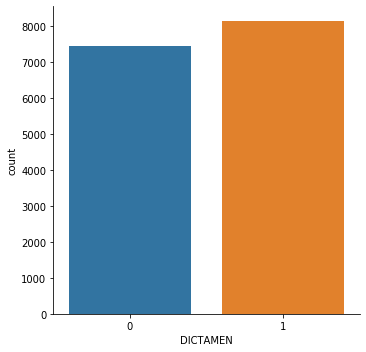

In [5]:
# "DICTAMEN" graph
sb.catplot("DICTAMEN", data=df, kind="count")

In [6]:
# Correlation with output variable
cor = df.corr()
cor_target = abs(cor["DICTAMEN"])
# Selecting the most highly correlated features to "DICTAMEN"
relevant_features = cor_target[cor_target>0.08]
relevant_features

ANO_NAC     0.082495
PLT_PROC    0.264051
OPI_NIBA    0.087744
GAN_CLIC    0.081875
SIT_LAB     0.084738
SER_HOR     0.087059
SER_INTE    0.109391
SER_PC      0.080891
VAC_RM      0.089627
DICTAMEN    1.000000
Name: DICTAMEN, dtype: float64

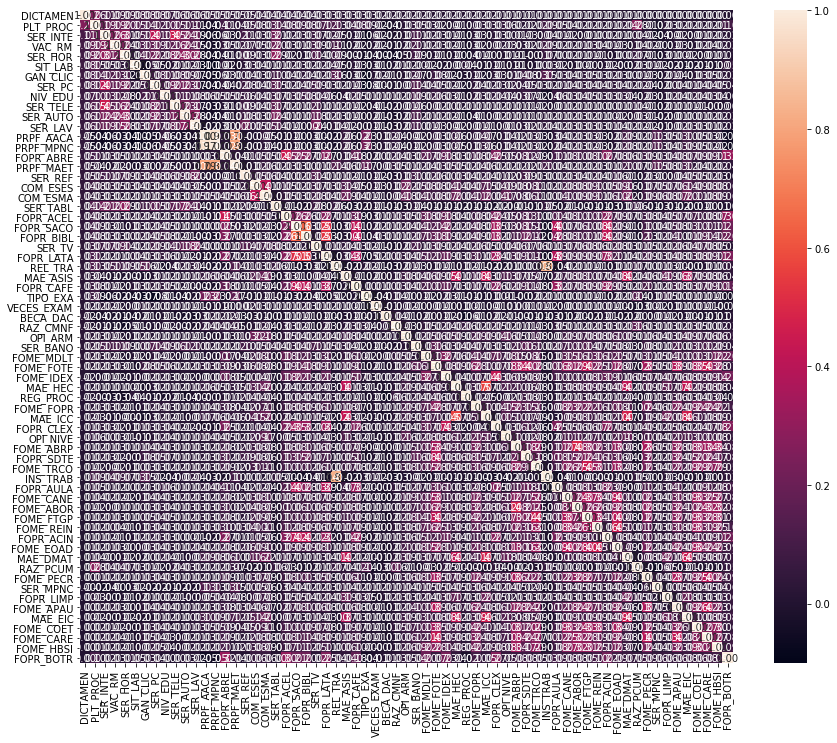

In [7]:
# DICTAMEN correlation matrix

# Number of variables for heatmap
k = 65
# Heatmap size
plt.figure(figsize=(15,12))
cols = cor.nlargest(k, 'DICTAMEN')['DICTAMEN'].index
cm = np.corrcoef(df[cols].values.T)
#sb.set(font_scale=1.25)
corhm = sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
# Selecting features
y = df['DICTAMEN']
X = df.drop(["DICTAMEN"], axis=1).values 

# Spliting dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [9]:
# Decision tree
decision_tree = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=0.9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=0.9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [10]:
y_pred=decision_tree.predict(X_test)

In [11]:
feature_imp = pd.Series(decision_tree.feature_importances_,index=df.drop(["DICTAMEN"], axis=1).columns).sort_values(ascending=False)
feature_imp[0:50]

PLT_PROC     0.557590
PRO_LIC      0.257803
TIPO_EXA     0.065796
SIT_LAB      0.036602
ANO_NAC      0.021282
SEXO         0.017051
OPI_NIBA     0.006705
TIEM_TRAB    0.005950
COM_ESAE     0.005229
CPV_CASA     0.004482
MAE_DMAT     0.003972
GAN_CLIC     0.003679
MAE_FAC      0.003674
CUARTOS      0.002607
MAE_ASIS     0.002511
SER_MAAC     0.001848
FOME_EOAD    0.001831
ESC_MAD      0.001388
FOPR_CAFE    0.000000
FOPR_ESDE    0.000000
FOPR_SDTE    0.000000
FOPR_SACO    0.000000
FOPR_ACIN    0.000000
FOPR_ACEL    0.000000
FOME_MDLT    0.000000
FOPR_LIMP    0.000000
FOPR_ABRE    0.000000
FOPR_BOTR    0.000000
FOME_IDEX    0.000000
FOPR_LATA    0.000000
FOME_PECR    0.000000
FOME_APAU    0.000000
FOME_CARE    0.000000
FOME_FOPR    0.000000
FOME_FOTE    0.000000
FOME_EXOR    0.000000
FOME_EXES    0.000000
FOPR_BIBL    0.000000
FOPR_ASAC    0.000000
FOPR_AULA    0.000000
OPI_NIVE     0.000000
LENG_MA      0.000000
LENG_PA      0.000000
RAZ_RAPT     0.000000
RAZ_RACT     0.000000
RAZ_OPT   

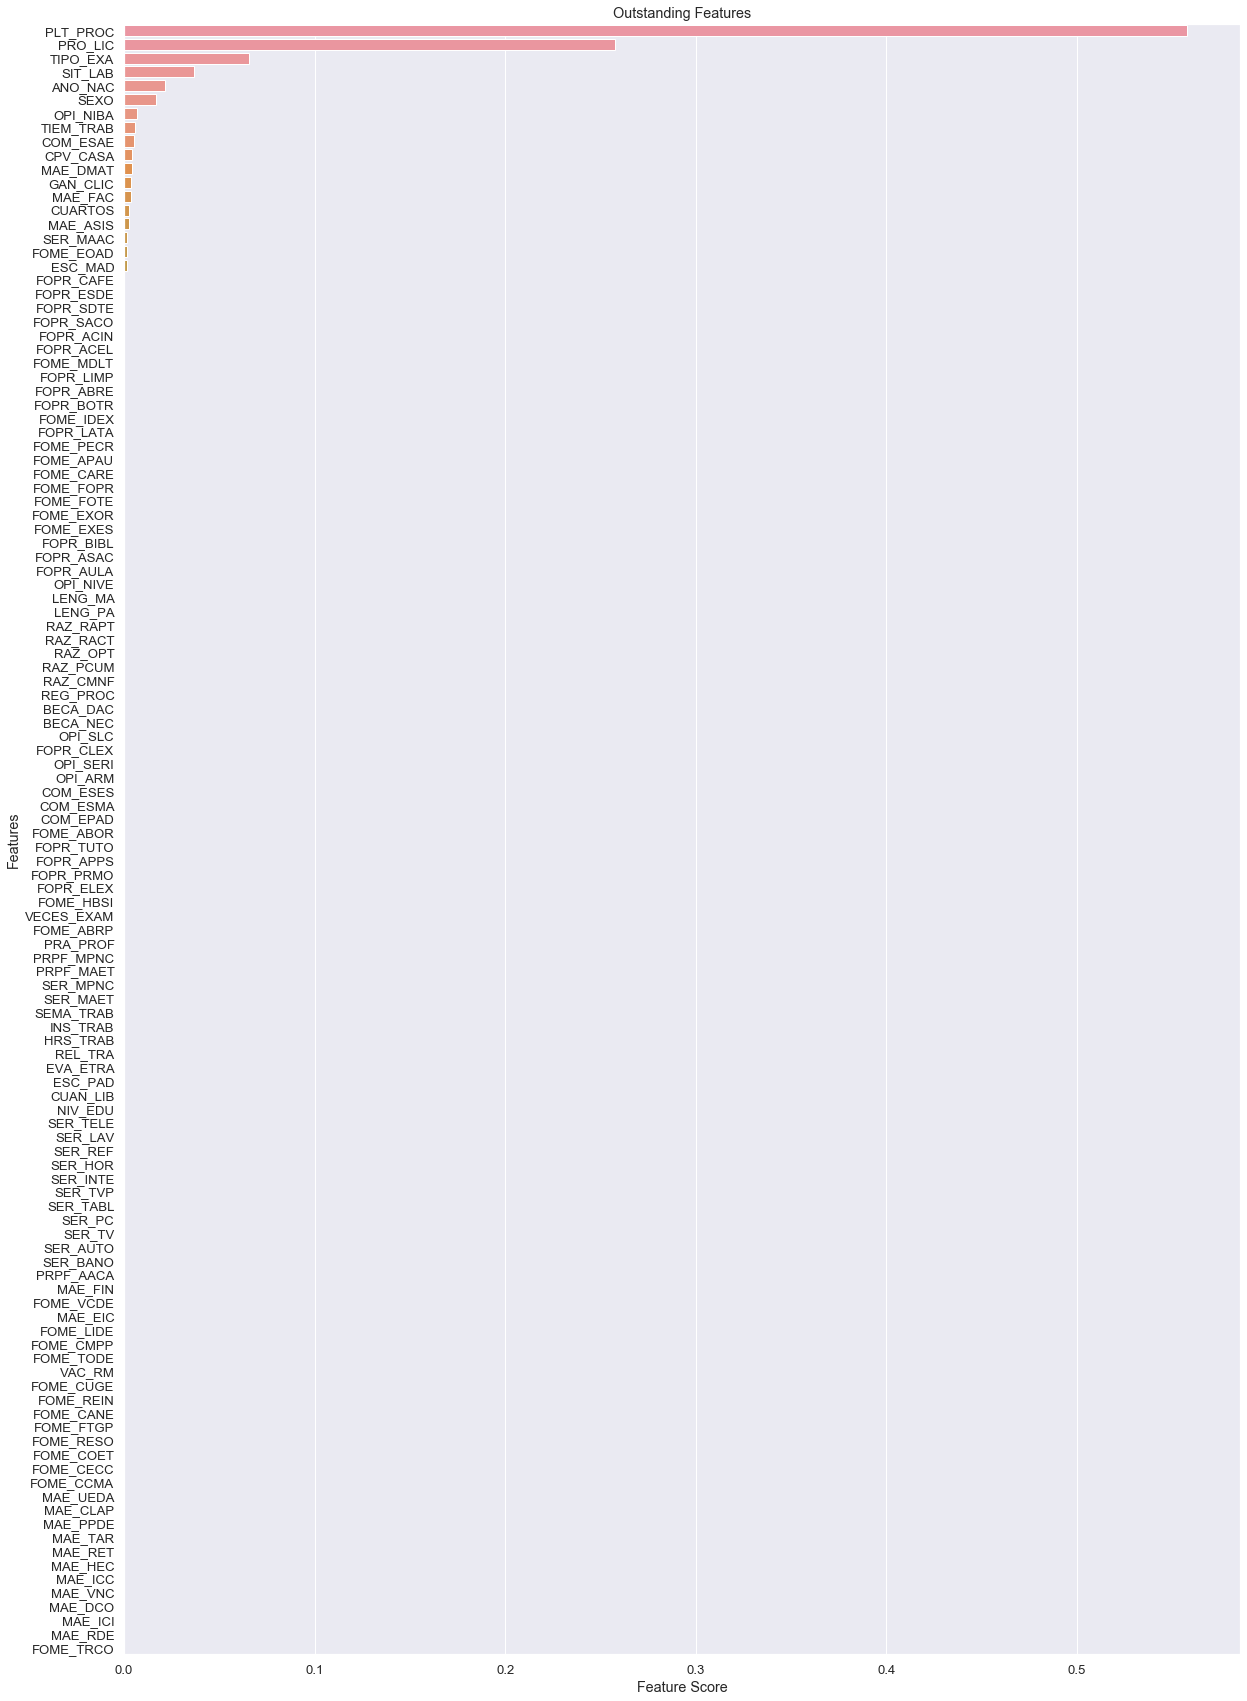

In [12]:
# Creating a bar plot
plt.figure(figsize=(20,30))
sb.set(font_scale=1.2)
sb.barplot(x=feature_imp, y=feature_imp.index)

# Labeling
plt.xlabel('Feature Score')
plt.ylabel('Features')
plt.title("Outstanding Features")
plt.show()

In [13]:
# Decision Tree Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6750640478223741


In [14]:
# Image tree (dot)
with open(r"tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(df.drop(["DICTAMEN"], axis=1)),
                              class_names = ["AUN NO SATISFACTORIO", "SATISFACTORIO"],
                              rounded = True,
                              filled= True )

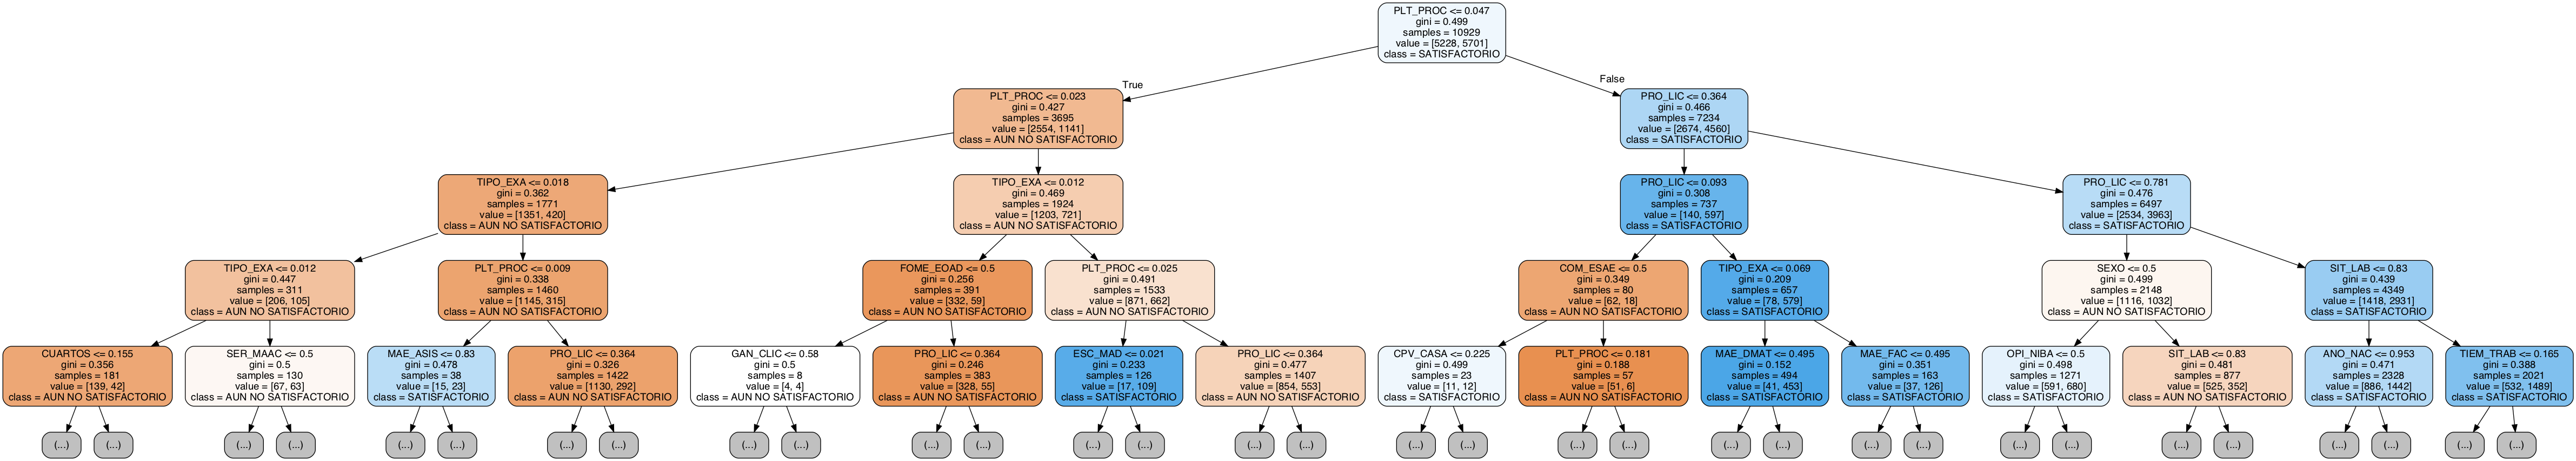

In [15]:
# Image tree (.png)
from PIL import Image
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
PImage("tree.png")

In [16]:
# Random Sample Test
x_test= df.sample() 
print(x_test)
y_pred = decision_tree.predict(x_test.drop(["DICTAMEN"], axis = 1))
print("Prediction: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(["DICTAMEN"], axis = 1))
print(y_proba)
print("Probability of succesful prediction: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

      TIPO_EXA  ANO_NAC  SEXO  LENG_MA  LENG_PA  PLT_PROC  RAZ_RAPT  RAZ_RACT  \
6367    0.0189  0.90625     0      0.0      0.0    0.1411       0.0       1.0   

      RAZ_OPT  RAZ_PCUM  ...  SER_TVP  SER_TABL  CUARTOS  SER_PC  SER_TV  \
6367      1.0       0.0  ...      1.0       0.0     0.41     1.0     1.0   

      SER_AUTO  SER_BANO  VAC_RM  DICTAMEN  VECES_EXAM  
6367       1.0       1.0     1.0         1         1.0  

[1 rows x 119 columns]
Prediction: [1]
[[0.21319797 0.78680203]]
Probability of succesful prediction: 78.68%
